# RAVE DR6 selection function

The RAVE (RAdial Velocity Experiment) target selection and associated selection function is described in [Wojno et al. (2017)](https://ui.adsabs.harvard.edu/abs/2017MNRAS.468.3368W/abstract), who construct it as count ratios relative to the 2MASS catalogue. The RAVE target selection was initially performed in the $I$ band (9 to 12). The survey in fact relies on predicted $I$ estimated from the 2MASS $J$ and $K_s$ bands. In some fields ($5^{\circ} < |b| < 25^{\circ}$) an additional requirement of $(J-K_s) > 0.5$ was imposed.

In this tutorial we show the construction of the selection function for RAVE DR6, computed as a function of Gaia magnitude $G$ and colour $G-R_P$.

## First step: querying the Gaia archive

The core of the problem here is to match the RAVE DR6 sample to the whole Gaia DR3 data set, and to group and count the sources. This can luckily be done in a single step, and entirely performed in a few minutes on the [Gaia archive](https://gea.esac.esa.int/archive/). The query itself might look intimidating, so let's see what is in there.

We rely on the cross-match table provided in the Gaia archive. The table ``gaiadr3.ravedr6_best_neighbour`` provides the correspondence between the Gaia table source id (``source_id``) and the RAVE object id (``original_ext_source_id``). The table `external.ravedr6` contains the RAVE DR6 catalogue, in which the object id is given as `rave_obs_id`. We join these tables using the ADQL command "OUTER JOIN", because we need to count all the sources in the Gaia data (and, separately, count all those that are also in RAVE DR6).

    select magnitude, colour, position, count(*) as n, sum(selection) as k
    from (
        select to_integer(floor((g.phot_g_mean_mag - 3)/1.0)) as magnitude,
        to_integer(floor((g.g_rp + 2.5)/0.5)) as colour,
        GAIA_HEALPIX_INDEX(5, source_id) as position,
        to_integer( IF_THEN_ELSE(rave.ra_input > 0, 1.0,0.0) ) as selection
    FROM gaiadr3.gaia_source AS g
    LEFT OUTER JOIN gaiadr3.ravedr6_best_neighbour AS xmatch USING (source_id)
    LEFT OUTER JOIN external.ravedr6 AS rave  ON (xmatch.original_ext_source_id = rave.rave_obs_id)
        WHERE g.phot_g_mean_mag<16
    ) as subquery
    group by magnitude, colour, position



<div class="alert alert-block alert-info">
    
        to_integer(floor((g.phot_g_mean_mag - 3)/1.0)) as magnitude,
    
        to_integer(floor((g.g_rp + 2.5)/0.5)) as colour,
    
This is where we indicate the binning scheme. We convert the magnitude of very source to an integer: G=3 to G=4 will be the magnitude bin number 0, G=4 to G=5 magnitude bin number 1, etc. </div>

<div class="alert alert-block alert-warning">
    
    GAIA_HEALPIX_INDEX(5, source_id) as position,
    
This indicates the healpix order used for the binning on the sky. Order 5 corresponds to pixels about 2 degrees in diameter. Larger numbers correspond to smaller areas (resulting in a finer spatial resolution, but a larger output file).
</div>

<div class="alert alert-block alert-success">
    
    to_integer( IF_THEN_ELSE(rave.ra_input > 0, 1.0,0.0) ) as selection
    
This is where we define which subset of the RAVE data we want the selection function constructed for. Here the filter is that RA must be positive, which is in fact true for all sources in the catalogue (RA ranges from 0 to 360) so this query constructs the selection function of the entire catalogue. Further down in this notebook we perform a similar query but restricted to stars with small radial velocity errors.
</div>

<div class="alert alert-block alert-danger">
    
       WHERE g.phot_g_mean_mag<16

We happen to know that RAVE is a shallow survey ($I$~12), so we can add this magnitude limit to save query time. Even if the computation is performed by the Gaia archive, I found that adding this line cuts down the query time to under 20min (vs over 1h without the magnitude cut). We can later verify that at $G=14$ the completeness is already zero, so cutting at 16 does not remove any useful bins.
</div>
    
I saved the output of this query locally as `rave_ratios_G16.fits`. **If you want to run this example on your computer, you need to run the above query first and save the file!

In [1]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt

t = Table.read('rave_ratios_G16.fits')

# print the first few rows:
t[:5]

magnitude,colour,position,n,k
int32,int32,int32,int64,int64
3,8,3905,1,0
6,7,9272,1,0
9,6,2220,45,0
2,5,11866,1,0
7,4,5479,1,0


In [2]:
t['hpx4'] = t['position'] // 4
t['hpx3'] = t['position'] // 16
t['hpx2'] = t['position'] // 64
t['hpx1'] = t['position'] // 256
t['hpx0'] = t['position'] // 1024

(-0.03, 1.03)

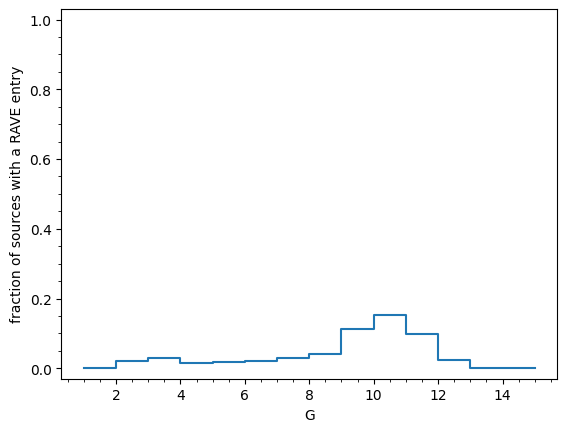

In [3]:
t_only_by_mag = t.group_by(['magnitude']).groups.aggregate(np.sum)

k_over_n = t_only_by_mag['k'] / t_only_by_mag['n']
plt.step( t_only_by_mag['magnitude']+3 , k_over_n , where='post')
plt.minorticks_on()
plt.xlabel('G')
plt.ylabel('fraction of sources with a RAVE entry')
plt.ylim(-0.03,1.03)

Text(0.5, 1.0, 'whole sky divided in 12 hpx0 regions')

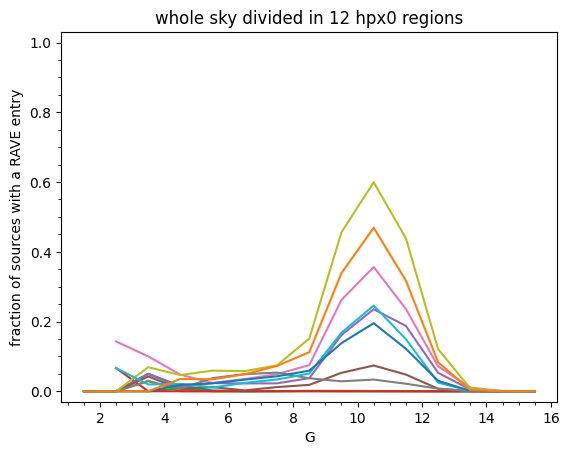

In [4]:
t_hpx0 = t.group_by(['magnitude','hpx0']).groups.aggregate(np.sum)


for hpxNb in range(12):
    t_this_hpx = t_hpx0[ t_hpx0['hpx0']==hpxNb ]
    k_over_n = t_this_hpx['k'] / t_this_hpx['n']
    plt.plot( t_this_hpx['magnitude'] + 3 + 0.5 , k_over_n )
    
plt.minorticks_on()
plt.xlabel('G')
plt.ylabel('fraction of sources with a RAVE entry')
plt.ylim(-0.03,1.03)
plt.title('whole sky divided in 12 hpx0 regions')

Text(0.5, 1.0, 'whole sky divided in 48 hpx1 regions')

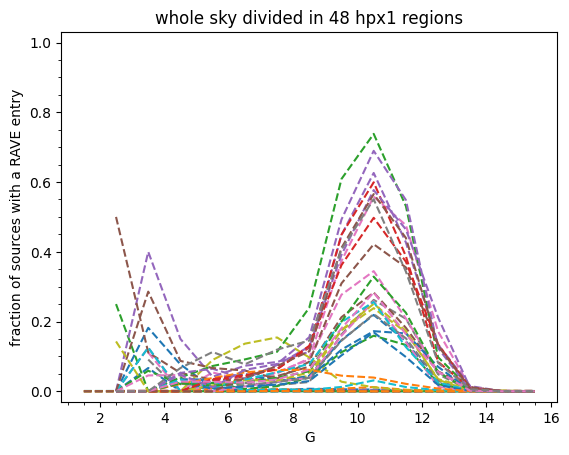

In [5]:
t_hpx1 = t.group_by(['magnitude','hpx1']).groups.aggregate(np.sum)


for hpxNb in range(48):
    t_this_hpx = t_hpx1[ t_hpx1['hpx1']==hpxNb ]
    k_over_n = t_this_hpx['k'] / t_this_hpx['n']
    plt.plot( t_this_hpx['magnitude'] + 3 + 0.5 , k_over_n , '--')
    
plt.minorticks_on()
plt.xlabel('G')
plt.ylabel('fraction of sources with a RAVE entry')
plt.ylim(-0.03,1.03)
plt.title('whole sky divided in 48 hpx1 regions')

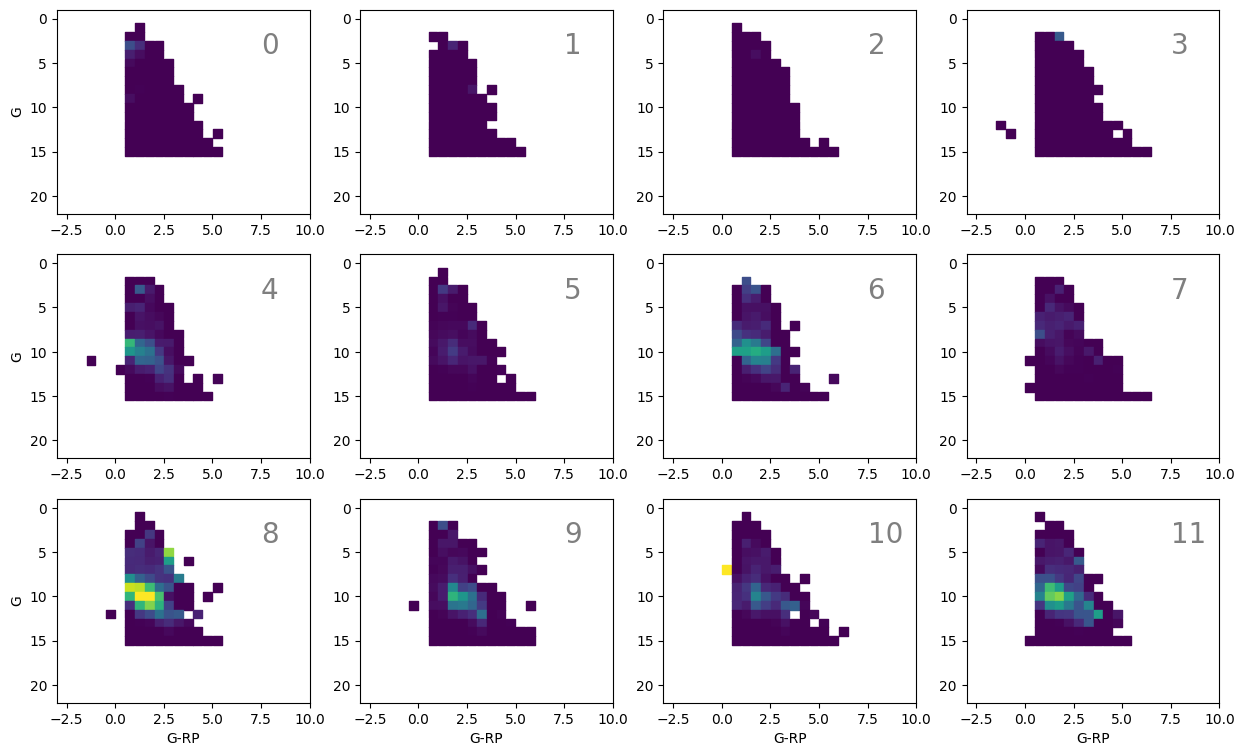

In [6]:
t_hpx0 = t.group_by(['magnitude','hpx0','colour']).groups.aggregate(np.sum)

plt.figure(figsize=(15,9))

for hpxNb in range(12):
    plt.subplot(3,4,hpxNb+1)
    t_this_hpx = t_hpx0[ t_hpx0['hpx0']==hpxNb ]
    k_over_n = t_this_hpx['k'] / t_this_hpx['n']
    
    plt.scatter( (t_this_hpx['colour']-2.5)*0.5 , t_this_hpx['magnitude']+3 , c=k_over_n ,
                vmin=0, vmax=0.6, marker='s',s=40)
    plt.ylim(22,-1)
    plt.xlim(-3,10)
    
    # add xlabel to the bottom row:
    if hpxNb+1>8:
        plt.xlabel('G-RP')
    # add ylabel to the left column:
    if hpxNb%4==0:
        plt.ylabel('G')
    # add healpix number
    plt.text(7.5,4,str(hpxNb),fontsize=20,alpha=0.5)
        

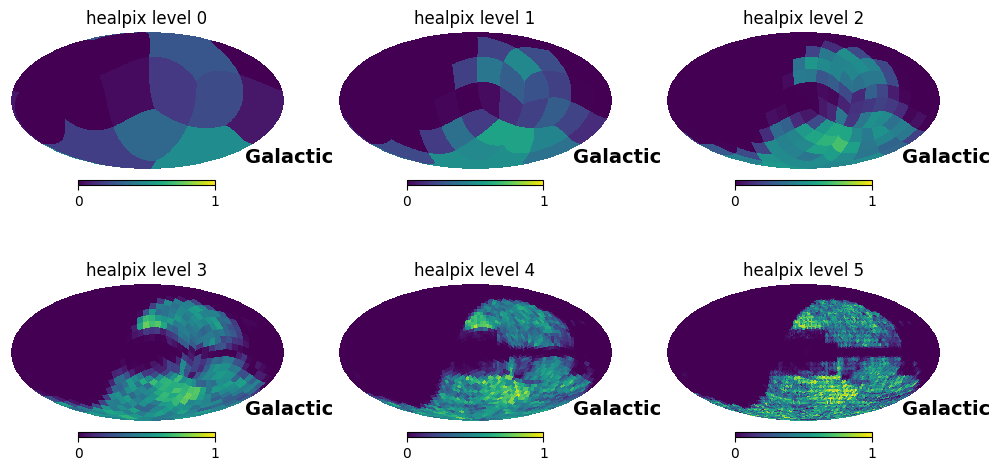

In [7]:
t_colourMagnitudeBin = t[ (t['magnitude']==8) & (t['colour']==6) ]

import healpy as hp

plt.figure(figsize=(12,6))

for lll,level in enumerate(['hpx0','hpx1','hpx2','hpx3','hpx4','position']):
    t_lowres = t_colourMagnitudeBin.group_by([level]).groups.aggregate(np.sum)
    ratios_lowres = t_lowres['k']/t_lowres['n']
    hpxNb_lowres = t_lowres[level]
    
    # Some might be empty, so we make a new list with the correct length and fill it:
    ratios_lowres_nogaps = np.empty(12*4**lll)
    ratios_lowres_nogaps[:] = np.nan
    for iii in range(len(ratios_lowres_nogaps)):
        try:
            ratios_lowres_nogaps[iii] = ratios_lowres[ t_lowres[level]==iii ][0]
        except:
            pass #we have no counts in there
        
    plt.subplot(2,3,lll+1)
    hp.mollview( ratios_lowres_nogaps , nest=True , coord='CG',hold=True,min=0,max=1,
               title='healpix level %i' % (lll) )

## Subset: RAVE DR6 stars with small radial velocity errors 

We now turn to the selection function of a particular subset of the RAVE DR6 catalogue. For this example, we focus on stars with radial velocity errors smaller than 1 km/s, a condition that we impose through the line: 

`to_integer( IF_THEN_ELSE(rave.hrv_error_sparv < 1, 1.0,0.0) ) as selection`

The complete query then becomes:

    select magnitude, colour, position, count(*) as n, sum(selection) as k
    from (
        select to_integer(floor((g.phot_g_mean_mag - 3)/1.0)) as magnitude,
        to_integer(floor((g.g_rp + 2.5)/0.5)) as colour,
        GAIA_HEALPIX_INDEX(5, source_id) as position,
        to_integer( IF_THEN_ELSE(rave.hrv_error_sparv < 1, 1.0,0.0) ) as selection
    FROM gaiadr3.gaia_source AS g
    LEFT OUTER JOIN gaiadr3.ravedr6_best_neighbour AS xmatch USING (source_id)
    LEFT OUTER JOIN external.ravedr6 AS rave  ON (xmatch.original_ext_source_id = rave.rave_obs_id)
        WHERE g.phot_g_mean_mag<16
    ) as subquery
    group by magnitude, colour, position

The follow plots show that this restricted sample is about 3 times less complete than the overall RAVE DR6 catalogue.

**Here again, to run this on your own computer you need to save the result of the above query in a local file!**

(0.0, 16.0)

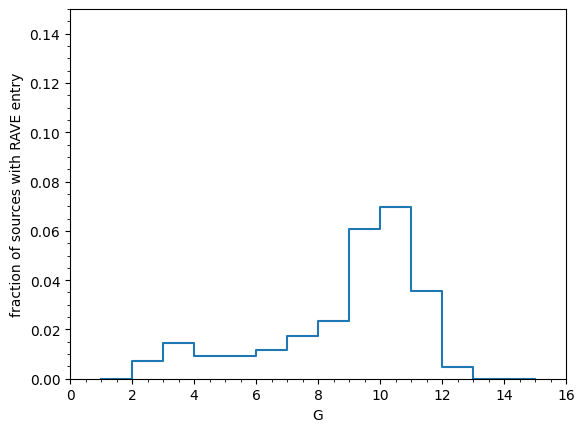

In [8]:
t = Table.read('rave_ratios_G16_hrv_error_1.fits')

t['hpx4'] = t['position'] // 4
t['hpx3'] = t['position'] // 16
t['hpx2'] = t['position'] // 64
t['hpx1'] = t['position'] // 256
t['hpx0'] = t['position'] // 1024

t_only_by_mag = t.group_by(['magnitude']).groups.aggregate(np.sum)

k_over_n = t_only_by_mag['k'] / t_only_by_mag['n']
plt.step( t_only_by_mag['magnitude']+3 , k_over_n , where='post')

plt.minorticks_on()
plt.xlabel('G')
plt.ylabel('fraction of sources with RAVE entry')
plt.ylim(0,0.15)
plt.xlim(0,16)

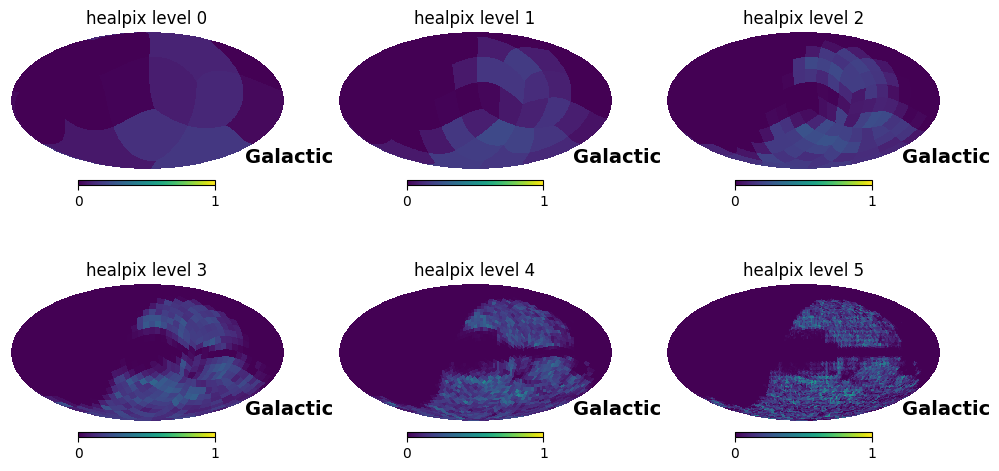

In [9]:
t_colourMagnitudeBin = t[ (t['magnitude']==8) & (t['colour']==6) ]

import healpy as hp

plt.figure(figsize=(12,6))

for lll,level in enumerate(['hpx0','hpx1','hpx2','hpx3','hpx4','position']):
    t_lowres = t_colourMagnitudeBin.group_by([level]).groups.aggregate(np.sum)
    ratios_lowres = t_lowres['k']/t_lowres['n']
    hpxNb_lowres = t_lowres[level]
    
    # Some might be empty, so we make a new list with the correct length and fill it:
    ratios_lowres_nogaps = np.empty(12*4**lll)
    ratios_lowres_nogaps[:] = np.nan
    for iii in range(len(ratios_lowres_nogaps)):
        try:
            ratios_lowres_nogaps[iii] = ratios_lowres[ t_lowres[level]==iii ][0]
        except:
            pass #we have no counts in there
        
    plt.subplot(2,3,lll+1)
    hp.mollview( ratios_lowres_nogaps , nest=True , coord='CG',hold=True,min=0,max=1.,
               title='healpix level %i' % (lll) )